In [1]:
import numpy as np
import functools
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [23]:
class ClusterByClassifier(BaseEstimator, ClusterMixin, TransformerMixin):
    
    def __init__(self, clf, n_clusters=8, max_iters=500, thresh=0.00001):
        self.n_clusters = n_clusters
        self.clf = clf
        self.max_iters = max_iters
        self.thresh = thresh
    
    def fit_predict(self, X, y=None):
        
        def train_and_predict(y):
            self.clf.fit(X, y)
            return np.array([np.random.choice(self.n_clusters, p=x) for x in self.clf.predict_proba(X)])
        
        def train_rec(y, ct=0):
            y_hat = train_and_predict(y)
            if ct >= self.max_iters or np.linalg.norm(y-y_hat) <= self.thresh:
                return y_hat
            else:
                return train_rec(y_hat, ct+1)
        
        return train_rec(np.random.randint(0, self.n_clusters, size=len(X)))
    
    def fit(self, X, y=None):
        self.fit_predict(X, y)
        
        return self
    
    def transform(self, X, y=None):
        """
        returns the distance to clusters, 
        where i define distance to be 1-proba
        """
        return 1.0 - self.clf.predict_proba(X)
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
        
    def score(self, X, y=None):
        return self.clf.predict_proba(X)
    

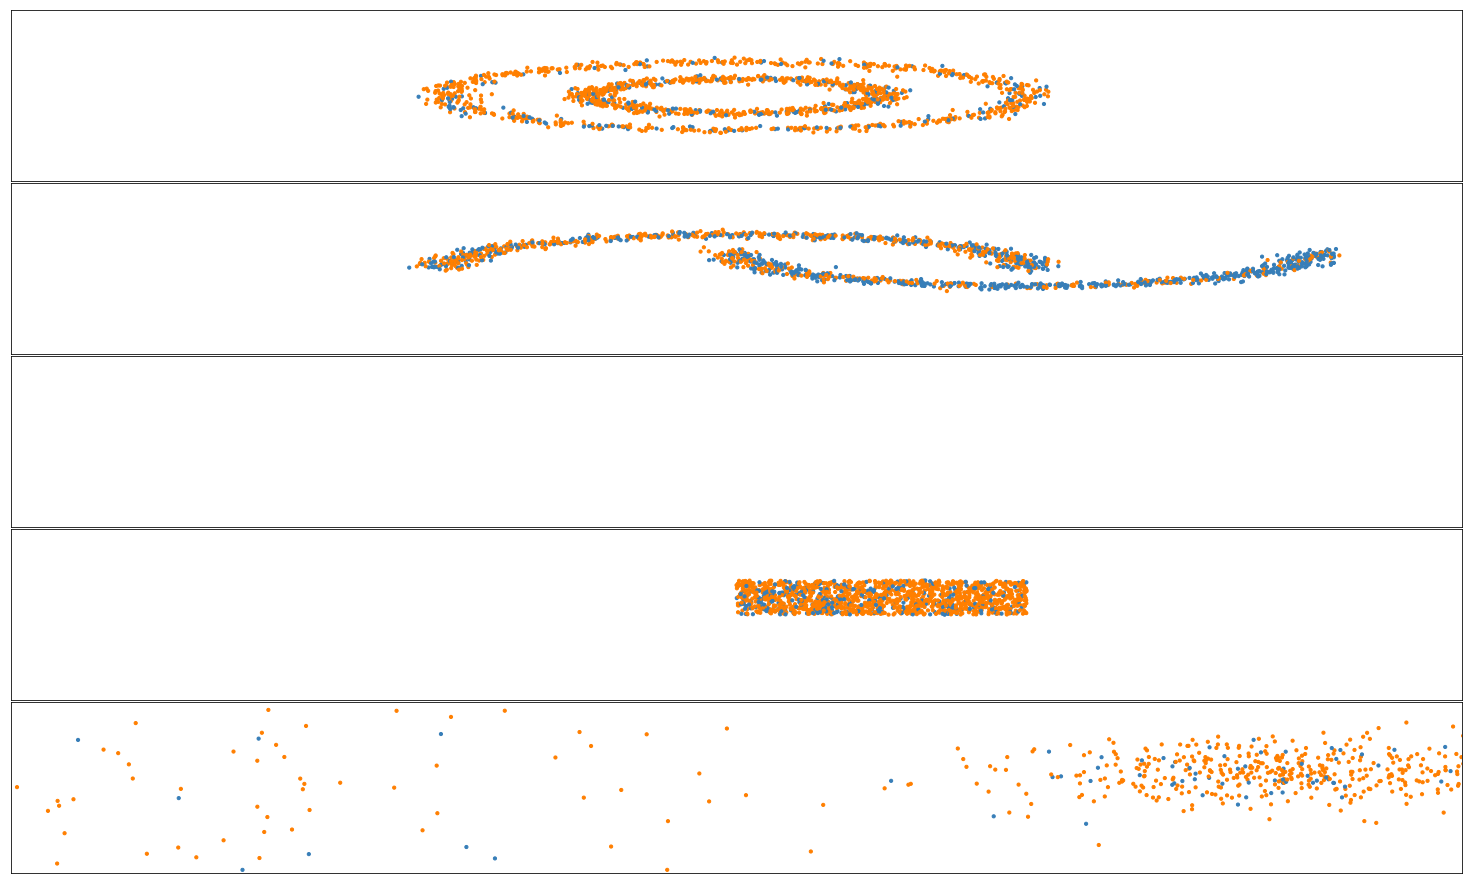

In [24]:
from sklearn import cluster, datasets, mixture
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle, islice
%matplotlib inline

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)


datasets = [
    noisy_circles,
    noisy_moons,
    blobs,
    no_structure,
    varied
]

plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

for i, dataset in enumerate(datasets):
    X = dataset[0]
    cl = ClusterByClassifier(LogisticRegression(solver='liblinear'), n_clusters=2)
    y_pred = cl.fit_predict(X)
    
    
    plt.subplot(len(datasets), 1, i+1)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                        int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
plt.show()